In [1]:
using Revise

In [2]:
using
    UnitsToValue,
    Printf,
    Plots,
    ImageFiltering
;

include("CaOH_package.jl")
include("helper_functions.jl")
include("analyze_results.jl")
include("load_save_results.jl")
;

[ Info: Precompiling QuantumStates [17f0441f-15e0-42ae-a101-302633ff8f0f]
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [636]:
λ = 626e-9
function get_toy_package()
    λ = 626e-9
    Γ = 2π* 6.4e6
    m = @with_unit 57 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4
    
    QN_bounds = (
        S = 1/2, 
        I = 1/2, 
        Λ = 0, 
        N = 0:3
    )
    X_state_basis = enumerate_states(HundsCaseB_Rot, QN_bounds)

    X_state_operator = :(
        BX * Rotation + 
        DX * RotationDistortion + 
        γX * SpinRotation + 
        bFX * Hyperfine_IS + 
        cX * (Hyperfine_Dipolar/3)
    )

    X_state_parameters = QuantumStates.@params begin
        BX = 10023.0841
        DX = 1.154e-2
        γX = 34.7593
        bFX = 2.602
        cX = 2.053
    end

    X_state_ham = Hamiltonian(basis=X_state_basis, operator=X_state_operator, parameters=X_state_parameters)

    # Add Zeeman terms
   
    X_state_ham = add_to_H(X_state_ham, :B_x, (gS * _μB * 1e-6) * Zeeman_x)
    X_state_ham = add_to_H(X_state_ham, :B_y, (gS * _μB * 1e-6) * Zeeman_y)
    X_state_ham = add_to_H(X_state_ham, :B_z, (gS * _μB * 1e-6) * Zeeman_z)
    X_state_ham.parameters.B_x = 0.
    X_state_ham.parameters.B_y = 0.
    X_state_ham.parameters.B_z = 0.

    evaluate!(X_state_ham)
    QuantumStates.solve!(X_state_ham)
    ;

    QN_bounds = (
        S = 1/2,
        I = 1/2,
        Λ = (-1,1),
        J = 1/2:5/2
    )
    A_state_basis = enumerate_states(HundsCaseA_Rot, QN_bounds)

    A_state_operator = :(
        T_A * DiagonalOperator +
        Be_A * Rotation + 
        Aso_A * SpinOrbit +
        q_A * ΛDoubling_q +
        p_A * ΛDoubling_p2q + q_A * (2ΛDoubling_p2q)
    )

    # Spectroscopic constants for CaOH, A state
    A_state_parameters = QuantumStates.@params begin
        T_A = 15998.122 * 299792458 * 1e-4
        Be_A = 0.3412200 * 299792458 * 1e-4
        Aso_A = 66.8181 * 299792458 * 1e-4
        p_A = -0.04287 * 299792458 * 1e-4
        q_A = -0.3257e-3 * 299792458 * 1e-4
    end

    A_state_ham = Hamiltonian(basis=A_state_basis, operator=A_state_operator, parameters=A_state_parameters)
    evaluate!(A_state_ham)
    QuantumStates.solve!(A_state_ham)
    ;

    A_state_J12_pos_parity_states = A_state_ham.states[5:8]

    QN_bounds = (
        S = 1/2, 
        I = 1/2, 
        Λ = (-1,1), 
        N = 0:3
    )
    A_state_caseB_basis = enumerate_states(HundsCaseB_Rot, QN_bounds)

    ground_states = [X_state_ham.states[6:8]; X_state_ham.states[12:16]]
#     ground_states = [X_state_ham.states[9:10]; X_state_ham.states[11:11]]; 
    # ground_states = X_state_ham.states[9:16]
    excited_states = convert_basis(A_state_J12_pos_parity_states, A_state_caseB_basis)[1:end]

    states = [ground_states; excited_states]
    n_excited = length(excited_states)
    n_states = length(states)

    for state ∈ states
        state.E *= 1e6
    end
    ;

    d = zeros(ComplexF64, n_states, n_states, 3)
    d_ge = zeros(ComplexF64, n_states - n_excited, n_excited, 3)

    basis_tdms = get_tdms_two_bases(X_state_ham.basis, A_state_caseB_basis, TDM)
    tdms_between_states!(d_ge, basis_tdms, ground_states, excited_states)
    d[1:n_states - n_excited, n_states-n_excited + 1:n_states, :] .= d_ge
    
#     Zeeman_x(state, state′) = (Zeeman(state, state′,-1) - Zeeman(state, state′,1))/sqrt(2)
#     Zeeman_y(state, state′) = im*(Zeeman(state, state′,-1) + Zeeman(state, state′,1))/sqrt(2)
#     Zeeman_z(state, state′) = Zeeman(state, state′, 0)

    Zeeman_x_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_x, ground_states, excited_states) .* (2π*gS*_μB/Γ))
    Zeeman_y_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_y, ground_states, excited_states) .* (2π*gS*_μB/Γ))
    Zeeman_z_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_z, ground_states, excited_states) .* (2π*gS*_μB/Γ))
                

    package = MutableNamedTuple(states=states, n_excited=n_excited, d=d, Zeeman_x_mat=Zeeman_x_mat, Zeeman_y_mat=Zeeman_y_mat, Zeeman_z_mat=Zeeman_z_mat, Γ = Γ , k = k, m = m)
    return package
end;


## Define CaOH Hamiltonian and molecular states

In [637]:
μ_B = 9.2740100783e-24
package = get_toy_package(); # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = get_toy_package(); # this includes more A states, for calculating AC Stark shift in the ODT.
k = package.k
Γ = package.Γ
m = package.m;

In [638]:
package.states[end-2]

State{HundsCaseB_Rot}(4.786209355421191e14, HundsCaseB_Rot[HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 0, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, -1, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 1/2, 1, 1, (N = 1:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, -1, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, 0, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 1, 1, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 2, -2, (N = 1:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -2.0:1.0:2.0)), HundsCaseB_Rot(0.0, 1/2, 1/2, -1, 1, 3/2, 2

In [639]:
energy.(package.states) .- energy(package.states[1])

12-element Vector{Float64}:
 0.0
 0.0
 0.0
 5.2747361937927246e7
 5.2747361937927246e7
 5.274736193793106e7
 5.274736193793106e7
 5.274736193793106e7
 4.7860092420572694e14
 4.7860092420572694e14
 4.7860092420572694e14
 4.7860092420572694e14

## Define experimental parameters

In [640]:
function get_Δ_from_exp(voltage, aom1_freq, aom2_freq)
    # return Δ1, Δ2 in MHz
    Δ1 = 52 - 7.4*(5.5-voltage)
    Δ3 = Δ1 + 51.24 - aom1_freq
    Δ4 = Δ1 + 51.24 - aom2_freq
    return Δ1, Δ3, Δ4
end


## Initial condition of the molecule cloud
temp = @with_unit 0.1 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 
## Define B field gradient and ramp time
B_gradient = -30 ; ramp_time = 4e-3

## Laser detunings
detuning_voltage = -0.5
aom1_freq = 53.75
aom2_freq = 52
# Δ1, Δ3, Δ2 = get_Δ_from_exp(detuning_voltage, aom1_freq, aom2_freq).*(1e6)
Δ4 = 0.0
Δ5 = 0.0

Δ1 = 7.5e6
Δ3 = 5e6



## Laser intensities
# intensity_voltage = 0.9
# power_total = intensity_voltage * 13.1 /2.2 # mW

# r1 = 3.7
# r3 = 2.8 
# r2 = 3.5 

# r1 = 1 
# r3 = 1
# r2 = 0

# p1 = r1/(r1+r2+r3) * power_total
# p3 = r3/(r1+r2+r3) * power_total
# p2 = r2/(r1+r2+r3) * power_total

# s1 = 2 * p1 / (π * 0.5^2) / 3.4
# s2 = 2 * p2 / (π * 0.5^2) / 3.4
# s3 = 2 * p3 / (π * 0.5^2) / 3.4
# s4 = 0.0
# s5 = 0.0

s1 = 3
s2 = 3
s3 = 0


blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 100,
                                pol1_x=σ⁺, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, pol5_x = σ⁺,
                                s1=s1, s2=s2, s3=s3, s4=s4, s5=s5,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, Δ5 =Δ5,

                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 7/9,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 5e-3,

                                diffusion_constant =0.0)
;

In [641]:
# 1+1 mot: bigger 2 photon det -> betting trapping but worse damping?

In [642]:
blue_MOT_params.n_values = 40
sequence = [blue_MOT_params]

durations = [20e-3]
generate_sequence!(sequence, durations);
@time results = simulate_particles_constant_diffusion(package, package_A, sequence);

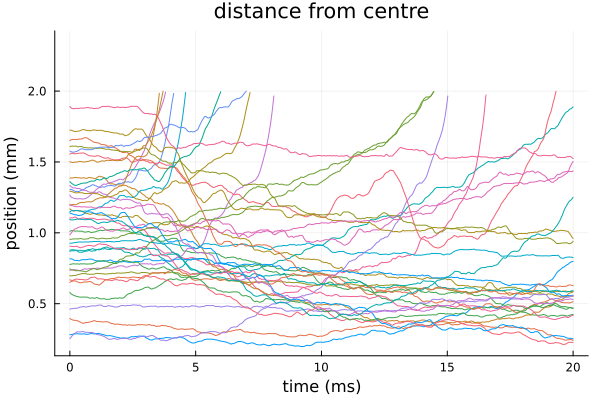

In [ ]:
plot_all_trajectories(results, "all")
plot!()

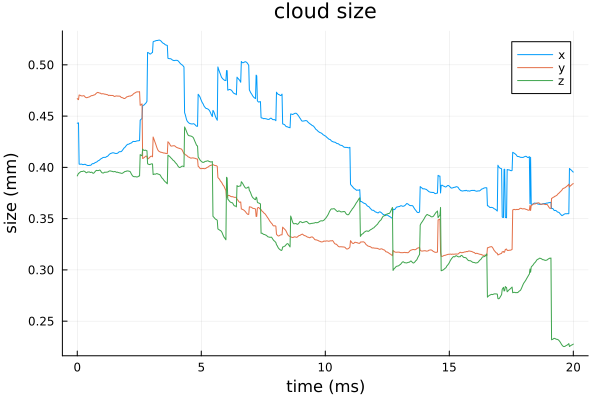

In [ ]:
plot_size(results,"all")
plot!()

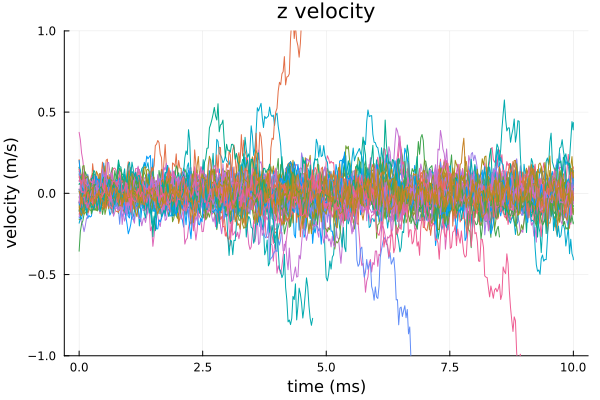

In [ ]:
plot_all_velocities(results,"z")
plot!(ylim=[-1,1])

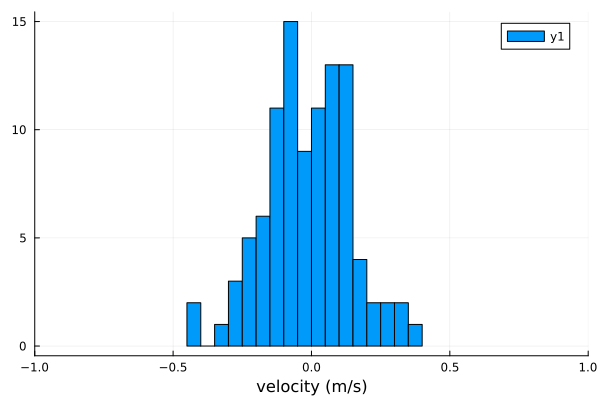

In [1036]:
t = 1
id_survived = survived_t(results, t)
dt = results.times[2][2]-results.times[2][1]
t_j = Int(floor(t ÷ dt))
    
x_grid = collect(LinRange(-1, 1, 20))
xs = [results.x_velocities[j][t_j] for j in id_survived]
density_x = distribution_to_func(x_grid, xs);
dx = 0.05
bins = Int((maximum(xs)-minimum(xs))÷dx)
histogram(xs, bins=bins,xlim=[-1,1], xlabel="velocity (m/s)")

In [505]:
# results_1D = results;
# results_3D = results;

In [749]:
results1 = bootstrap_iteration(results_3D,n_values=100);

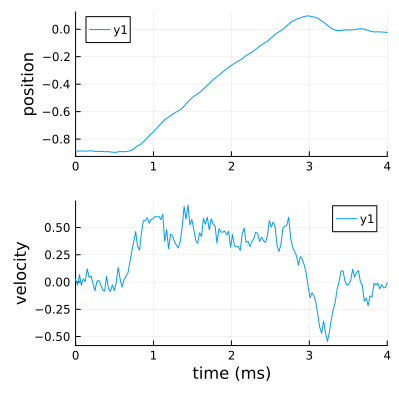

In [810]:
i +=1
p1 = plot(results.times[i], results.z_trajectories[i], ylabel="position",xlim=[0,4])
p2 = plot(results.times[i], results.z_velocities[i], ylabel="velocity",xlim=[0,4],xlabel="time (ms)")
plot(p1, p2, layout = (2,1),size=[400,400])

In [811]:
plot!(dpi=300)
savefig("trajectory_example.png")

"G:\\My Drive\\github\\OpticalBlochEquations\\examples\\CaOH_toy_model\\trajectory_example.png"

In [765]:
# plot_all_trajectories(results1, "z")
# plot!(ylim=[-2,2])

In [764]:
# plot_all_velocities(results1,"z")
# plot!(ylim=[-1,1],xlim=[-0.1,2])

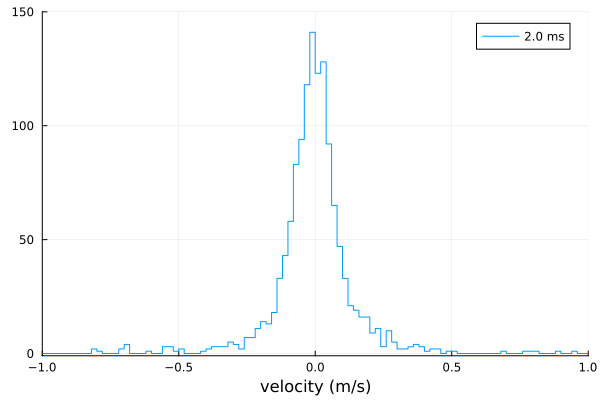

In [697]:
t = 2
id_survived = survived_t(results_3D, t)
dt = results_3D.times[1][2]-results_3D.times[1][1]
t_j = Int(floor(t ÷ dt))
    
x_grid = collect(LinRange(-1, 1, 50))
xs = [results_3D.z_velocities[j][t_j] for j in id_survived]
density_x = distribution_to_func(x_grid, xs);
dx = 0.02
bins = Int((maximum(xs)-minimum(xs))÷dx)
p5 = stephist(xs, bins=bins,xlim=[-1,1], xlabel="velocity (m/s)",label=@sprintf("%.1f ms",t), ylim=[-1,150])
# plot(x_grid, density_x)

[ Info: Saved animation to G:\My Drive\github\OpticalBlochEquations\examples\CaOH_toy_model\tmp.gif


Plots.AnimatedGif("G:\\My Drive\\github\\OpticalBlochEquations\\examples\\CaOH_toy_model\\tmp.gif")
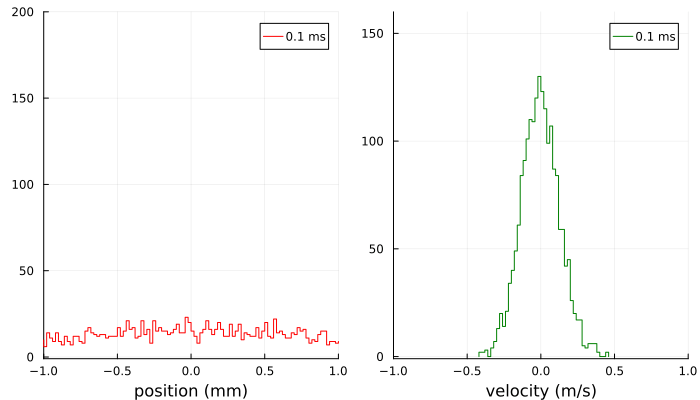

In [815]:
using Plots

# Define a function to generate plots
function animate(frames)
    anim = @gif for t in frames
        id_survived = survived_t(results_3D, t)
        dt = results_3D.times[1][2]-results_3D.times[1][1]
        t_j = Int(floor(t ÷ dt))

        x_grid = collect(LinRange(-1, 1, 50))
        xs = [results_3D.z_trajectories[j][t_j] for j in id_survived]
        density_x = distribution_to_func(x_grid, xs);
        dx = 0.02
        bins = Int((maximum(xs)-minimum(xs))÷dx)
        p1 = stephist(xs, bins=bins,xlim=[-1,1], xlabel="position (mm)",label=@sprintf("%.1f ms",t), ylim=[-1,200],color=:red)
        xs = [results_3D.z_velocities[j][t_j] for j in id_survived]
        density_x = distribution_to_func(x_grid, xs);
        dx = 0.02
        bins = Int((maximum(xs)-minimum(xs))÷dx)
        p2 = stephist(xs, bins=bins,xlim=[-1,1], xlabel="velocity (m/s)",label=@sprintf("%.1f ms",t), ylim=[-1,160],color=:green)
        plot(p1,p2,layout=(1,2),size=[700,400])
    end
    
    return anim
end

# Number of frames in the animation
frames = 0.05:0.025:2

# Generate animation
anim = animate(frames)

# Display animation
anim


In [544]:

using
    DifferentialEquations,
    LinearAlgebra
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using Parameters

import ProgressMeter: Progress, next!

import OpticalBlochEquations.simulate_particles_constant_diffusion
import OpticalBlochEquations.make_problem_with_param_constant_diffusion

function update_H_and_∇H(H, p, r, t)
    
    # Define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Zeeman_Hx = p.extra_data.Zeeman_Hx
    Zeeman_Hy = p.extra_data.Zeeman_Hy
    
    τ_bfield = p.sim_params.B_ramp_time 
    scalar = t/τ_bfield
    scalar = min(scalar, 1.0)
    
    gradient_x = -scalar * p.sim_params.B_gradient * 1e2 / k/2 
    gradient_y = +scalar * p.sim_params.B_gradient * 1e2 / k/2 
    gradient_z = -scalar * p.sim_params.B_gradient * 1e2 / k 
    
    Bx = gradient_x * r[1] + p.sim_params.B_offset[1]
    By = gradient_y * r[2] + p.sim_params.B_offset[2]
    Bz = gradient_z * r[3] + p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
    end
    
    # Update the Hamiltonian for the molecule-ODT interaction
    H_ODT = p.extra_data.H_ODT_static
    
    ODT_size = p.sim_params.ODT_size .* p.k
    update_ODT_center!(p, t)
    ODT_x = p.extra_data.ODT_position[1] * p.k
    ODT_z = p.extra_data.ODT_position[2] * p.k
    
    scalar_ODT = exp(-2(r[1]-ODT_x)^2/ODT_size[1]^2) * exp(-2r[2]^2/ODT_size[2]^2) * exp(-2(r[3]-ODT_z)^2/ODT_size[3]^2)
    
    @turbo for i in eachindex(H)
        H.re[i] += H_ODT.re[i] * scalar_ODT
        H.im[i] += H_ODT.im[i] * scalar_ODT
    end
    
    # return SVector{3,ComplexF64}(0,0,0)
    return SVector{3,ComplexF64}((-4(r[1]-ODT_x) / ODT_size[1]^2) * scalar_ODT, (-4r[2] / ODT_size[2]^2) * scalar_ODT, (-4(r[3]-ODT_z) / ODT_size[3]^2) * scalar_ODT)
    
end
;

function make_problem_with_param_constant_diffusion(molecule_package, package_A, param; randomize_initial_vector = true, ψ0=nothing)       
    Γ = molecule_package.Γ
    k = molecule_package.k
    m = molecule_package.m
    ħ = 1.0545718176461565e-34
    λ = 2π/k 

    t_start = param.t_start
    t_end = param.t_end
    pol1_x, pol2_x, pol3_x, pol4_x, pol5_x = param.pol1_x, param.pol2_x, param.pol3_x, param.pol4_x, param.pol5_x

    s1, s2, s3, s4, s5 = param.s1, param.s2, param.s3, param.s4, param.s5
    s_ramp_time = param.s_ramp_time * Γ
    s_ramp_factor = param.s_ramp_to_factor
    
    Δ1, Δ2, Δ3, Δ4, Δ5 = param.Δ1, param.Δ2, param.Δ3, param.Δ4, param.Δ5
    B_gradient = param.B_gradient
    temp = param.temp
    diameter = param.diameter
    B_ramp_time = param.B_ramp_time * Γ
    displacement = param.displacement
    kick = param.kick
    
    imbalance = param.pol_imbalance 
    sx_imbalance, sy_imbalance, sz_imbalance = param.s_imbalance[1], param.s_imbalance[2], param.s_imbalance[3] 
    x_center_y, x_center_z, y_center_x, y_center_z, z_center_x, z_center_y = param.off_center .* k
    retro_loss = param.retro_loss
    
    #x_center_y *= rand()
    #x_center_z *= rand()
    #y_center_x *= rand()
    #y_center_z *= rand()
    #z_center_x *= rand()
    #z_center_y *= rand()
    
    dark_lifetime = param.dark_lifetime
    FC_mainline = param.FC_mainline
    
    x_dist, vx_dist = init_MOT_distribution(temp, diameter, displacement[1], kick[1],m)
    y_dist, vy_dist = init_MOT_distribution(temp, diameter, displacement[2], kick[2],m)
    z_dist, vz_dist = init_MOT_distribution(temp, diameter, displacement[3], kick[3],m)
  
    states = molecule_package.states
    n_excited = molecule_package.n_excited
    d = molecule_package.d
    Zeeman_x_mat = molecule_package.Zeeman_x_mat
    Zeeman_y_mat = molecule_package.Zeeman_y_mat
    Zeeman_z_mat = molecule_package.Zeeman_z_mat
    
    kx = x̂ + [0, param.pointing_error[1],param.pointing_error[2]]
    kx = kx ./ sqrt(kx[1]^2 + kx[2]^2 + kx[3]^2)
    ky = ŷ + [param.pointing_error[3],0.0,param.pointing_error[4]]
    ky = ky ./ sqrt(ky[1]^2 + ky[2]^2 + ky[3]^2)
    kz = ẑ + [param.pointing_error[5],param.pointing_error[6],0.0]
    kz = kz / sqrt(kz[1]^2 + kz[2]^2 + kz[3]^2)
    
    ODT_intensity = param.ODT_intensity # 13.3*1e3/(50e-4)^2
    ODT_size = param.ODT_size # (30e-6, 2e-3, 30e-6)

    α = param.ODT_revolutions
    r_max = param.ODT_rmax * 1.1
    t_max = param.ODT_tmax * 1.1

    n = 1000
    arclengths = zeros(n)
    # spiral: r = τ; theta = 2πα * τ
    τs = LinRange(0,1.1,n)
    dτ = τs[2]-τs[1]
    length_curr = 0.0

    for i in 1:n
        r = r_max/1 * τs[i]
        θ = 2*π * α * τs[i]
        length_curr += sqrt((r_max/1)^2 +(2π*α*r)^2) * dτ
        arclengths[i] = length_curr
    end

    velocity = length_curr / t_max
    ts = arclengths / velocity
    
   photon_budget = param.photon_budget

    
    n_states = length(states)
    particle = OpticalBlochEquations.Particle()
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    H₀ = zeros(ComplexF64, n_states, n_states)
    
    extra_data = MutableNamedTuple(
        Zeeman_Hx=Zeeman_x_mat,
        Zeeman_Hy=Zeeman_y_mat,
        Zeeman_Hz=Zeeman_z_mat,
        H_ODT_static = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        H_ODT = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        ODT_position = [0.0, 0.0]
        
    )
    
    sim_params = MutableNamedTuple(
        B_gradient = param.B_gradient,
        B_offset = (param.Bx_offset,param.By_offset,param.Bz_offset),
        n_excited = n_excited,
        B_ramp_time = B_ramp_time,
        photon_budget = rand(Exponential(photon_budget)),
        ODT_size = ODT_size,
        dark_lifetime = param.dark_lifetime,
        FC_mainline = param.FC_mainline,

        ODT_rmax = param.ODT_rmax,
        ODT_tmax = param.ODT_tmax,
        ODT_revolutions = param.ODT_revolutions,
        ODT_motion_t_start = param.ODT_motion_t_start,
        ODT_motion_t_stop = param.ODT_motion_t_stop,
        interpolation_times = ts, interpolation_τs = τs,
        
        s_total = s1 + s2 + s3 + s4,
        diffusion_constant = param.diffusion_constant
        )

    t_span = (t_start, t_end) ./ (1/Γ);
    
    ω1 = 2π * (states[end].E - states[1].E) + 2π * Δ1
    ω2 = 2π * (states[end].E - states[6].E) + 2π * Δ2
    ω3 = 2π * (states[end].E - states[6].E) + 2π * Δ3
    ω4 = 2π * (states[end].E - states[6].E) + 2π * Δ4
    ω5 = 2π * (states[end].E - states[6].E) + 2π * Δ5

    ϵ_(ϵ, f) = t -> ϵ
    s_func(s) = (x,t) -> s
    s_gaussian(s, axes, centers) = (r,t) -> s * gaussian_intensity_along_axes(r, axes, centers,k)
    
    s_gaussian_ramp(s, factor, ramp_time, axes, centers) = (r,t) -> ((s*factor-s)/ramp_time * min(t, ramp_time) + s) * gaussian_intensity_along_axes(r, axes, centers,k)
    
    
    # ϵ_(ϵ, f) = t -> exp(-im*2π*f*t/500) .* ϵ
    
    rand1 = rand()
    pol1_x = pol1_x.*sqrt(1 - imbalance) + flip(pol1_x).*sqrt(imbalance)*exp(im*2π*rand1)
    rand2 = rand()
    pol2_x = pol2_x.*sqrt(1 - imbalance) + flip(pol2_x).*sqrt(imbalance)*exp(im*2π*rand2)
    rand3 = rand()
    pol3_x = pol3_x.*sqrt(1 - imbalance) + flip(pol3_x).*sqrt(imbalance)*exp(im*2π*rand3)
    rand4 = rand()
    pol4_x = pol4_x.*sqrt(1 - imbalance) + flip(pol4_x).*sqrt(imbalance)*exp(im*2π*rand4)
    rand5 = rand()
    pol5_x = pol5_x.*sqrt(1 - imbalance) + flip(pol5_x).*sqrt(imbalance)*exp(im*2π*rand5)    

    sx_rand = 1/2-rand()
    sy_rand = 1/2-rand()
    sz_rand = 1/2-rand()
    
    ϕs = [exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand())]
    s1x = s1 * (1+sx_imbalance*sx_rand)
    s1y = s1 * (1+sy_imbalance*sy_rand)
    s1z = s1 * (1+sz_imbalance*sz_rand)
    k̂ = kx; ϵ1 = ϕs[1]*rotate_pol(pol1_x, k̂); ϵ_func1 = ϵ_(ϵ1, 1); laser1 = Field(k̂, ϵ_func1, ω1,  s_gaussian_ramp(s1x, s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ2 = ϕs[2]*rotate_pol(pol1_x, k̂); ϵ_func2 = ϵ_(ϵ2, 2); laser2 = Field(k̂, ϵ_func2, ω1, s_gaussian_ramp(s1x*(1-retro_loss), s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = ky; ϵ3 = ϕs[3]*rotate_pol(pol1_x, k̂); ϵ_func3 = ϵ_(ϵ3, 3); laser3 = Field(k̂, ϵ_func3, ω1,  s_gaussian_ramp(s1y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ4 = ϕs[4]*rotate_pol(pol1_x, k̂); ϵ_func4 = ϵ_(ϵ4, 4); laser4 = Field(k̂, ϵ_func4, ω1,  s_gaussian_ramp(s1y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ5 = ϕs[5]*rotate_pol(flip(pol1_x), k̂); ϵ_func5 = ϵ_(ϵ5, 5); laser5 = Field(k̂, ϵ_func5, ω1,  s_gaussian_ramp(s1z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ6 = ϕs[6]*rotate_pol(flip(pol1_x), k̂); ϵ_func6 = ϵ_(ϵ6, 6); laser6 = Field(k̂, ϵ_func6, ω1, s_gaussian_ramp(s1z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_1 = [laser1, laser2, laser3, laser4, laser5, laser6]

    s2x = s2 * (1+sx_imbalance*sx_rand)
    s2y = s2 * (1+sy_imbalance*sy_rand)
    s2z = s2 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ7 = ϕs[1]*rotate_pol(pol2_x, k̂); ϵ_func7 = ϵ_(ϵ7, 1); laser7 = Field(k̂, ϵ_func7, ω2, s_gaussian_ramp(s2x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ8 = ϕs[2]*rotate_pol(pol2_x, k̂); ϵ_func8 = ϵ_(ϵ8, 2); laser8 = Field(k̂, ϵ_func8, ω2, s_gaussian_ramp(s2x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ9 = ϕs[3]*rotate_pol(pol2_x, k̂); ϵ_func9 = ϵ_(ϵ9, 3); laser9 = Field(k̂, ϵ_func9, ω2, s_gaussian_ramp(s2y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ10 = ϕs[4]*rotate_pol(pol2_x, k̂); ϵ_func10 = ϵ_(ϵ10, 4); laser10 = Field(k̂, ϵ_func10, ω2, s_gaussian_ramp(s2y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ11 = ϕs[5]*rotate_pol(flip(pol2_x), k̂); ϵ_func11 = ϵ_(ϵ11, 5); laser11 = Field(k̂, ϵ_func11, ω2, s_gaussian_ramp(s2z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ12 = ϕs[6]*rotate_pol(flip(pol2_x), k̂); ϵ_func12 = ϵ_(ϵ12, 6); laser12 = Field(k̂, ϵ_func12, ω2, s_gaussian_ramp(s2z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_2 = [laser7, laser8, laser9, laser10, laser11, laser12]

    s3x = s3 * (1+sx_imbalance*sx_rand)
    s3y = s3 * (1+sy_imbalance*sy_rand)
    s3z = s3 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ13 = ϕs[1]*rotate_pol(pol3_x, k̂); ϵ_func13 = ϵ_(ϵ13, 1); laser13 = Field(k̂, ϵ_func13, ω3, s_gaussian_ramp(s3x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ14 = ϕs[2]*rotate_pol(pol3_x, k̂); ϵ_func14 = ϵ_(ϵ14, 2); laser14 = Field(k̂, ϵ_func14, ω3, s_gaussian_ramp(s3x*(1-retro_loss),s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ15 = ϕs[3]*rotate_pol(pol3_x, k̂); ϵ_func15 = ϵ_(ϵ15, 3); laser15 = Field(k̂, ϵ_func15, ω3, s_gaussian_ramp(s3y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ16 = ϕs[4]*rotate_pol(pol3_x, k̂); ϵ_func16 = ϵ_(ϵ16, 4); laser16 = Field(k̂, ϵ_func16, ω3, s_gaussian_ramp(s3y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ17 = ϕs[5]*rotate_pol(flip(pol3_x), k̂); ϵ_func17 = ϵ_(ϵ17, 5); laser17 = Field(k̂, ϵ_func17, ω3, s_gaussian_ramp(s3z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ18 = ϕs[6]*rotate_pol(flip(pol3_x), k̂); ϵ_func18 = ϵ_(ϵ18, 6); laser18 = Field(k̂, ϵ_func18, ω3, s_gaussian_ramp(s3z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_3 = [laser13, laser14, laser15, laser16, laser17, laser18]

    s4x = s4 * (1+sx_imbalance*sx_rand)
    s4y = s4 * (1+sy_imbalance*sy_rand)
    s4z = s4 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ19 = ϕs[1]*rotate_pol(pol4_x, k̂); ϵ_func19 = ϵ_(ϵ19, 1); laser19 = Field(k̂, ϵ_func19, ω4,s_gaussian_ramp(s4x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ20 = ϕs[2]*rotate_pol(pol4_x, k̂); ϵ_func20 = ϵ_(ϵ20, 2); laser20 = Field(k̂, ϵ_func20, ω4, s_gaussian_ramp(s4x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ21 = ϕs[3]*rotate_pol(pol4_x, k̂); ϵ_func21 = ϵ_(ϵ21, 3); laser21 = Field(k̂, ϵ_func21, ω4, s_gaussian_ramp(s4y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ22 = ϕs[4]*rotate_pol(pol4_x, k̂); ϵ_func22 = ϵ_(ϵ22, 4); laser22 = Field(k̂, ϵ_func22, ω4, s_gaussian_ramp(s4y*(1-retro_loss),s_ramp_factor, s_ramp_time,   (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ23 = ϕs[5]*rotate_pol(flip(pol4_x), k̂); ϵ_func23 = ϵ_(ϵ23, 5); laser23 = Field(k̂, ϵ_func23, ω4, s_gaussian_ramp(s4z,s_ramp_factor, s_ramp_time,   (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ24 = ϕs[6]*rotate_pol(flip(pol4_x), k̂); ϵ_func24 = ϵ_(ϵ24, 6); laser24 = Field(k̂, ϵ_func24, ω4, s_gaussian_ramp(s4z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_4 = [laser19, laser20, laser21, laser22, laser23, laser24]

    s5x = s5 * (1+sx_imbalance*sx_rand)
    s5y = s5 * (1+sy_imbalance*sy_rand)
    s5z = s5 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ25 = ϕs[1]*rotate_pol(pol5_x, k̂); ϵ_func25 = ϵ_(ϵ25, 1); laser25 = Field(k̂, ϵ_func25, ω5, s_gaussian_ramp(s5x, s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ26 = ϕs[2]*rotate_pol(pol5_x, k̂); ϵ_func26 = ϵ_(ϵ26, 2); laser26 = Field(k̂, ϵ_func26, ω5, s_gaussian_ramp(s5x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ27 = ϕs[3]*rotate_pol(pol5_x, k̂); ϵ_func27 = ϵ_(ϵ27, 3); laser27 = Field(k̂, ϵ_func27, ω5, s_gaussian_ramp(s5y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ28 = ϕs[4]*rotate_pol(pol5_x, k̂); ϵ_func28 = ϵ_(ϵ28, 4); laser28 = Field(k̂, ϵ_func28, ω5, s_gaussian_ramp(s5y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ29 = ϕs[5]*rotate_pol(flip(pol5_x), k̂); ϵ_func29 = ϵ_(ϵ29, 5); laser29 = Field(k̂, ϵ_func29, ω5, s_gaussian_ramp(s5z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ30 = ϕs[6]*rotate_pol(flip(pol5_x), k̂); ϵ_func30 = ϵ_(ϵ30, 6); laser30 = Field(k̂, ϵ_func30, ω5, s_gaussian_ramp(s5z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    
    lasers_5 = [laser25, laser26, laser27, laser28, laser29, laser30]

    lasers = [lasers_1; lasers_2; lasers_3; lasers_4; lasers_5]
        
    p = schrodinger_stochastic_constant_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p)

    if randomize_initial_vector
        randomize_initial_vector!(prob.p, x_dist, y_dist, z_dist, vx_dist, vy_dist, vz_dist)
        random_initial_state!(prob.p)
     else
        prob.p.ψ .= ψ0
     end
    
    return prob
end

function gaussian_intensity_along_axes(r, axes, centers,k)
    """1/e^2 width = 5mm Gaussian beam """  
    return 1
end

function simulate_particles_constant_diffusion(package, package_A, sequence_of_params)
    
    n_values = sequence_of_params[1].n_values
    n_threads=Threads.nthreads()
    batch_size = fld(n_values, n_threads)
    remainder = n_values - batch_size * n_threads
    prog_bar = Progress(n_values)

    n_states = length(package.states)
    n_excited = package.n_excited

    x_trajectories = Array{Vector{Float64}}(fill([],n_values))
    y_trajectories = Array{Vector{Float64}}(fill([],n_values)) 
    z_trajectories = Array{Vector{Float64}}(fill([],n_values))
    x_velocities = Array{Vector{Float64}}(fill([],n_values))
    y_velocities = Array{Vector{Float64}}(fill([],n_values))
    z_velocities = Array{Vector{Float64}}(fill([],n_values))
    A_populations = Array{Vector{Float64}}(fill([],n_values))
    times = Array{Vector{Float64}}(fill([],n_values))
    photons_scattered = zeros(n_values)

                            
    results = MutableNamedTuple(x_trajectories = x_trajectories, y_trajectories= y_trajectories, z_trajectories=z_trajectories,
                                x_velocities = x_velocities, y_velocities=y_velocities, z_velocities=z_velocities,
                                times=times, A_populations=A_populations,
                                n_values=n_values, photons_scattered=photons_scattered, n_states = n_states, n_excited=n_excited,
                                Γ = package.Γ, k=package.k)

    cb = ContinuousCallback(condition, SE_collapse_pol_constant_diffusion!, nothing, save_positions=(false,false))

    Threads.@threads for i ∈ 1:n_threads
    
        _batch_size = i <= remainder ? (batch_size + 1) : batch_size
        batch_start_idx = 1 + (i <= remainder ? (i - 1) : remainder) + batch_size * (i-1)

        for j ∈ batch_start_idx:(batch_start_idx + _batch_size - 1) 
            ψ0 = nothing
            for i_param in 1:length(sequence_of_params)
                randomize = false
                if i_param == 1
                     randomize = true
                end
                params = sequence_of_params[i_param]      
                prob_copy = make_problem_with_param_constant_diffusion(package, package_A, params, randomize_initial_vector = randomize, ψ0=ψ0)
                ψ0 = continue_particle_constant_diffusion!(j, results, prob_copy)    
                if abs(params.t_end - results.times[j][end]*1e-3) > 1e-3
                          break # this particle has already died
                end
            end

            next!(prog_bar)
        end
    end
    
    return results
end
                                
                                
                                


import OpticalBlochEquations.SE_collapse_pol_constant_diffusion!
function SE_collapse_pol_constant_diffusion!(integrator)

    p = integrator.p
    n_states = p.n_states
    n_excited = p.n_excited
    n_ground = p.n_ground
    d = p.d
    ψ = integrator.u
    
    
 
    
    # A photon is observed.
    # Measure the polarization of the photon along z.
    p⁺ = 0.0
    p⁰ = 0.0
    p⁻ = 0.0
    
    for i ∈ 1:n_excited
        ψ_pop = norm(ψ[n_ground + i])^2
        for j ∈ 1:n_ground
            p⁺ += ψ_pop * norm(d[j,n_ground+i,1])^2
            p⁰ += ψ_pop * norm(d[j,n_ground+i,2])^2
            p⁻ += ψ_pop * norm(d[j,n_ground+i,3])^2
        end
        # note the polarization p in d[:,:,p] is defined to be m_e - m_g, 
        # whereas the polarization of the emitted photon is m_g - m_e
    end
    
    p_norm = p⁺ + p⁰ + p⁻
    rn = rand() * p_norm
    for i ∈ 1:n_ground
        ψ[i] = 0.0
    end
    
    pol = 0
    if 0 < rn <= p⁺ # photon is measured to have polarization σ⁺
        pol = 1
    elseif p⁺ < rn <= p⁺ + p⁰ # photon is measured to have polarization σ⁰
        pol = 2
    else # photon is measured to have polarization σ⁻
        pol = 3
    end
    
    for i in 1:n_ground
        for j in (n_ground+1):n_states
            ψ[i] += ψ[j] * d[i,j,pol]
        end
    end
    
    # zero excited state amplitudes
    for i ∈ (n_ground + 1):n_states
        ψ[i] = 0.0
    end
    
    ψ_norm = 0.0
    for i ∈ 1:n_states
        ψ_norm += norm(ψ[i])^2
    end
    ψ_norm = sqrt(ψ_norm)
    for i ∈ 1:n_states
        ψ[i] /= ψ_norm
    end
    
    p.n_scatters += 1
    
    # zero excited state populations
    for i ∈ (n_states+1):(n_states+n_excited)
        integrator.u[i] = 0.0
    end

    
    dp = sample_direction(1)
    dv = dp ./ p.mass
    integrator.u[n_states + n_excited + 4] += dv[1]
    integrator.u[n_states + n_excited + 5] += dv[2]
    integrator.u[n_states + n_excited + 6] += dv[3]
    
    time_before_decay = integrator.t - p.last_decay_time
    
    rand1 = rand()
    diffusion_direction = 1.0
    if rand1 < 0.5
        diffusion_direction= -1
    end
    integrator.u[n_states + n_excited + 4] += p.diffusion_constant*sqrt(time_before_decay)/p.mass * diffusion_direction
    
    rand1 = rand()
    diffusion_direction = 1.0
    if rand1 < 0.5
        diffusion_direction= -1
    end
    integrator.u[n_states + n_excited + 5] += p.diffusion_constant*sqrt(time_before_decay)/p.mass * diffusion_direction
    
    rand1 = rand()
    diffusion_direction = 1.0
    if rand1 < 0.5
        diffusion_direction= -1
    end
    integrator.u[n_states + n_excited + 6] += p.diffusion_constant*sqrt(time_before_decay)/p.mass * diffusion_direction
    
    p.last_decay_time = integrator.t
    
    p.time_to_decay = rand(p.decay_dist)
    return nothing
end
                                                                                        
                                                                                        
import OpticalBlochEquations.make_problem_with_param_diffusion
function make_problem_with_param_diffusion(molecule_package, package_A, param; randomize_initial_vector = true, ψ0=nothing)       
    Γ = molecule_package.Γ
    k = molecule_package.k
    m = molecule_package.m
    ħ = 1.0545718176461565e-34
    λ = 2π/k         
                
    t_start = param.t_start
    t_end = param.t_end
    pol1_x, pol2_x, pol3_x, pol4_x = param.pol1_x, param.pol2_x, param.pol3_x, param.pol4_x

    s1, s2, s3, s4 = param.s1, param.s2, param.s3, param.s4
    s_ramp_time = param.s_ramp_time * Γ
    s_ramp_factor = param.s_ramp_to_factor
    
    Δ1, Δ2, Δ3, Δ4 = param.Δ1, param.Δ2, param.Δ3, param.Δ4
    B_gradient = param.B_gradient
    temp = param.temp
    diameter = param.diameter
    B_ramp_time = param.B_ramp_time * Γ
    displacement = param.displacement
    kick = param.kick
    
    imbalance = param.pol_imbalance 
    sx_imbalance, sy_imbalance, sz_imbalance = param.s_imbalance[1], param.s_imbalance[2], param.s_imbalance[3] 
    x_center_y, x_center_z, y_center_x, y_center_z, z_center_x, z_center_y = param.off_center .* k
    retro_loss = param.retro_loss
    
    #x_center_y *= rand()
    #x_center_z *= rand()
    #y_center_x *= rand()
    #y_center_z *= rand()
    #z_center_x *= rand()
    #z_center_y *= rand()
    
    dark_lifetime = param.dark_lifetime
    FC_mainline = param.FC_mainline
    
    x_dist, vx_dist = init_MOT_distribution(temp, diameter, displacement[1], kick[1], m)
    y_dist, vy_dist = init_MOT_distribution(temp, diameter, displacement[2], kick[2], m)
    z_dist, vz_dist = init_MOT_distribution(temp, diameter, displacement[3], kick[3], m)
  
    states = molecule_package.states
    n_excited = molecule_package.n_excited
    d = molecule_package.d
    Zeeman_x_mat = molecule_package.Zeeman_x_mat
    Zeeman_y_mat = molecule_package.Zeeman_y_mat
    Zeeman_z_mat = molecule_package.Zeeman_z_mat
    
    kx = x̂ + [0, param.pointing_error[1],param.pointing_error[2]]
    kx = kx ./ sqrt(kx[1]^2 + kx[2]^2 + kx[3]^2)
    ky = ŷ + [param.pointing_error[3],0.0,param.pointing_error[4]]
    ky = ky ./ sqrt(ky[1]^2 + ky[2]^2 + ky[3]^2)
    kz = ẑ + [param.pointing_error[5],param.pointing_error[6],0.0]
    kz = kz / sqrt(kz[1]^2 + kz[2]^2 + kz[3]^2)
    
    ODT_intensity = param.ODT_intensity # 13.3*1e3/(50e-4)^2
    ODT_size = param.ODT_size # (30e-6, 2e-3, 30e-6)

    α = param.ODT_revolutions
    r_max = param.ODT_rmax * 1.1
    t_max = param.ODT_tmax * 1.1

    n = 1000
    arclengths = zeros(n)
    # spiral: r = τ; theta = 2πα * τ
    τs = LinRange(0,1.1,n)
    dτ = τs[2]-τs[1]
    length_curr = 0.0

    for i in 1:n
        r = r_max/1 * τs[i]
        θ = 2*π * α * τs[i]
        length_curr += sqrt((r_max/1)^2 +(2π*α*r)^2) * dτ
        arclengths[i] = length_curr
    end

    velocity = length_curr / t_max
    ts = arclengths / velocity
    
    
    photon_budget = param.photon_budget

    
    n_states = length(states)
    particle = OpticalBlochEquations.Particle()
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    H₀ = zeros(ComplexF64, n_states, n_states)
    
    extra_data = MutableNamedTuple(
        Zeeman_Hx=Zeeman_x_mat,
        Zeeman_Hy=Zeeman_y_mat,
        Zeeman_Hz=Zeeman_z_mat,
        H_ODT_static = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        H_ODT = StructArray(get_ODT_Hamiltonian_matrix(molecule_package, package_A, ODT_intensity, [0,1.0,0])),
        ODT_position = [0.0, 0.0]
        
    )
    
    sim_params = MutableNamedTuple(
        B_gradient = param.B_gradient,
        B_offset = (param.Bx_offset,param.By_offset,param.Bz_offset),
        n_excited = n_excited,
        B_ramp_time = B_ramp_time,
        photon_budget = rand(Exponential(photon_budget)),
        ODT_size = ODT_size,
        dark_lifetime = param.dark_lifetime,
        FC_mainline = param.FC_mainline,

        ODT_rmax = param.ODT_rmax,
        ODT_tmax = param.ODT_tmax,
        ODT_revolutions = param.ODT_revolutions,
        ODT_motion_t_start = param.ODT_motion_t_start,
        ODT_motion_t_stop = param.ODT_motion_t_stop,
        interpolation_times = ts, interpolation_τs = τs,

        dt = param.dt
        )

    t_span = (t_start, t_end) ./ (1/Γ)
    
    ω1 = 2π * (states[end].E - states[1].E) + Δ1 * 2π
    ω2 = 2π * (states[end].E - states[1].E)  + Δ2 * 2π
    ω3 = 2π * (states[end].E - states[5].E)  + Δ3 * 2π
    ω4 = 2π * (states[end].E - states[5].E)  + Δ4 * 2π

    ϵ_(ϵ, f) = t -> ϵ
    s_func(s) = (x,t) -> s
    s_gaussian(s, axes, centers) = (r,t) -> s * gaussian_intensity_along_axes(r, axes, centers,k)
    
    s_gaussian_ramp(s, factor, ramp_time, axes, centers) = (r,t) -> ((s*factor-s)/ramp_time * min(t, ramp_time) + s) * gaussian_intensity_along_axes(r, axes, centers,k)
    
    
    # ϵ_(ϵ, f) = t -> exp(-im*2π*f*t/500) .* ϵ
    
    rand1 = rand()
    pol1_x = pol1_x.*sqrt(1 - imbalance) + flip(pol1_x).*sqrt(imbalance)*exp(im*2π*rand1)
    rand2 = rand()
    pol2_x = pol2_x.*sqrt(1 - imbalance) + flip(pol2_x).*sqrt(imbalance)*exp(im*2π*rand2)
    rand3 = rand()
    pol3_x = pol3_x.*sqrt(1 - imbalance)  + flip(pol3_x).*sqrt(imbalance)*exp(im*2π*rand3)
    rand4 = rand()
    pol4_x = pol4_x.*sqrt(1 - imbalance) + flip(pol4_x).*sqrt(imbalance)*exp(im*2π*rand4)
    
    sx_rand = 1.0#1/2-rand()
    sy_rand = 1.0#1/2-rand()
    sz_rand = 1.0#1/2-rand()
    
    ϕs = [exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand()),exp(im*2π*rand())]
    s1x = s1 * (1+sx_imbalance*sx_rand)
    s1y = s1 * (1+sy_imbalance*sy_rand)
    s1z = s1 * (1+sz_imbalance*sz_rand)
    k̂ = kx; ϵ1 = ϕs[1]*rotate_pol(pol1_x, k̂); ϵ_func1 = ϵ_(ϵ1, 1); laser1 = Field(k̂, ϵ_func1, ω1,  s_gaussian_ramp(s1x, s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ2 = ϕs[2]*rotate_pol(pol1_x, k̂); ϵ_func2 = ϵ_(ϵ2, 2); laser2 = Field(k̂, ϵ_func2, ω1, s_gaussian_ramp(s1x*(1-retro_loss), s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = ky; ϵ3 = ϕs[3]*rotate_pol(pol1_x, k̂); ϵ_func3 = ϵ_(ϵ3, 3); laser3 = Field(k̂, ϵ_func3, ω1,  s_gaussian_ramp(s1y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ4 = ϕs[4]*rotate_pol(pol1_x, k̂); ϵ_func4 = ϵ_(ϵ4, 4); laser4 = Field(k̂, ϵ_func4, ω1,  s_gaussian_ramp(s1y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ5 = ϕs[5]*rotate_pol(flip(pol1_x), k̂); ϵ_func5 = ϵ_(ϵ5, 5); laser5 = Field(k̂, ϵ_func5, ω1,  s_gaussian_ramp(s1z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ6 = ϕs[6]*rotate_pol(flip(pol1_x), k̂); ϵ_func6 = ϵ_(ϵ6, 6); laser6 = Field(k̂, ϵ_func6, ω1, s_gaussian_ramp(s1z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_1 = [laser1, laser2, laser3, laser4, laser5, laser6]

    s2x = s2 * (1+sx_imbalance*sx_rand)
    s2y = s2 * (1+sy_imbalance*sy_rand)
    s2z = s2 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ7 = ϕs[1]*rotate_pol(pol2_x, k̂); ϵ_func7 = ϵ_(ϵ7, 1); laser7 = Field(k̂, ϵ_func7, ω2, s_gaussian_ramp(s2x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ8 = ϕs[2]*rotate_pol(pol2_x, k̂); ϵ_func8 = ϵ_(ϵ8, 2); laser8 = Field(k̂, ϵ_func8, ω2, s_gaussian_ramp(s2x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ9 = ϕs[3]*rotate_pol(pol2_x, k̂); ϵ_func9 = ϵ_(ϵ9, 3); laser9 = Field(k̂, ϵ_func9, ω2, s_gaussian_ramp(s2y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ10 = ϕs[4]*rotate_pol(pol2_x, k̂); ϵ_func10 = ϵ_(ϵ10, 4); laser10 = Field(k̂, ϵ_func10, ω2, s_gaussian_ramp(s2y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ11 = ϕs[5]*rotate_pol(flip(pol2_x), k̂); ϵ_func11 = ϵ_(ϵ11, 5); laser11 = Field(k̂, ϵ_func11, ω2, s_gaussian_ramp(s2z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ12 = ϕs[6]*rotate_pol(flip(pol2_x), k̂); ϵ_func12 = ϵ_(ϵ12, 6); laser12 = Field(k̂, ϵ_func12, ω2, s_gaussian_ramp(s2z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_2 = [laser7, laser8, laser9, laser10, laser11, laser12]

    s3x = s3 * (1+sx_imbalance*sx_rand)
    s3y = s3 * (1+sy_imbalance*sy_rand)
    s3z = s3 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ13 = ϕs[1]*rotate_pol(pol3_x, k̂); ϵ_func13 = ϵ_(ϵ13, 1); laser13 = Field(k̂, ϵ_func13, ω3, s_gaussian_ramp(s3x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ14 = ϕs[2]*rotate_pol(pol3_x, k̂); ϵ_func14 = ϵ_(ϵ14, 2); laser14 = Field(k̂, ϵ_func14, ω3, s_gaussian_ramp(s3x*(1-retro_loss),s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ15 = ϕs[3]*rotate_pol(pol3_x, k̂); ϵ_func15 = ϵ_(ϵ15, 3); laser15 = Field(k̂, ϵ_func15, ω3, s_gaussian_ramp(s3y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ16 = ϕs[4]*rotate_pol(pol3_x, k̂); ϵ_func16 = ϵ_(ϵ16, 4); laser16 = Field(k̂, ϵ_func16, ω3, s_gaussian_ramp(s3y*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ17 = ϕs[5]*rotate_pol(flip(pol3_x), k̂); ϵ_func17 = ϵ_(ϵ17, 5); laser17 = Field(k̂, ϵ_func17, ω3, s_gaussian_ramp(s3z, s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ18 = ϕs[6]*rotate_pol(flip(pol3_x), k̂); ϵ_func18 = ϵ_(ϵ18, 6); laser18 = Field(k̂, ϵ_func18, ω3, s_gaussian_ramp(s3z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_3 = [laser13, laser14, laser15, laser16, laser17, laser18]

    s4x = s4 * (1+sx_imbalance*sx_rand)
    s4y = s4 * (1+sy_imbalance*sy_rand)
    s4z = s4 * (1+sz_imbalance*sz_rand)
    k̂ = +kx; ϵ19 = ϕs[1]*rotate_pol(pol4_x, k̂); ϵ_func19 = ϵ_(ϵ19, 1); laser19 = Field(k̂, ϵ_func19, ω4,s_gaussian_ramp(s4x,s_ramp_factor, s_ramp_time,  (2,3), (x_center_y, x_center_z)))
    k̂ = -kx; ϵ20 = ϕs[2]*rotate_pol(pol4_x, k̂); ϵ_func20 = ϵ_(ϵ20, 2); laser20 = Field(k̂, ϵ_func20, ω4, s_gaussian_ramp(s4x*(1-retro_loss), s_ramp_factor, s_ramp_time, (2,3), (x_center_y, x_center_z)))
    k̂ = +ky; ϵ21 = ϕs[3]*rotate_pol(pol4_x, k̂); ϵ_func21 = ϵ_(ϵ21, 3); laser21 = Field(k̂, ϵ_func21, ω4, s_gaussian_ramp(s4y, s_ramp_factor, s_ramp_time,  (1,3), (y_center_x, y_center_z)))
    k̂ = -ky; ϵ22 = ϕs[4]*rotate_pol(pol4_x, k̂); ϵ_func22 = ϵ_(ϵ22, 4); laser22 = Field(k̂, ϵ_func22, ω4, s_gaussian_ramp(s4y*(1-retro_loss),s_ramp_factor, s_ramp_time,   (1,3), (y_center_x, y_center_z)))
    k̂ = +kz; ϵ23 = ϕs[5]*rotate_pol(flip(pol4_x), k̂); ϵ_func23 = ϵ_(ϵ23, 5); laser23 = Field(k̂, ϵ_func23, ω4, s_gaussian_ramp(s4z,s_ramp_factor, s_ramp_time,   (1,2), (z_center_x, z_center_y)))
    k̂ = -kz; ϵ24 = ϕs[6]*rotate_pol(flip(pol4_x), k̂); ϵ_func24 = ϵ_(ϵ24, 6); laser24 = Field(k̂, ϵ_func24, ω4, s_gaussian_ramp(s4z*(1-retro_loss), s_ramp_factor, s_ramp_time,  (1,2), (z_center_x, z_center_y)))

    lasers_4 = [laser19, laser20, laser21, laser22, laser23, laser24]

    lasers = [lasers_1;lasers_2; lasers_3; lasers_4]
                            
    p = schrodinger_stochastic_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; 
        sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

    prob = ODEProblem(ψ_stochastic_diffusion!, p.ψ, t_span, p)
    
    if randomize_initial_vector
        randomize_initial_vector!(prob.p, x_dist, y_dist, z_dist, vx_dist, vy_dist, vz_dist)
        random_initial_state!(prob.p)
     else
        prob.p.ψ .= ψ0
     end

     reset_operator_diagonal!(prob.p.P_x, prob.p.ψ[n_states + n_excited + 4] * prob.p.mass)
     reset_operator_diagonal!(prob.p.P_y, prob.p.ψ[n_states + n_excited + 5] * prob.p.mass)
     reset_operator_diagonal!(prob.p.P_z, prob.p.ψ[n_states + n_excited + 6] * prob.p.mass)
     
     reset_operator_diagonal!(prob.p.Px_sq, (prob.p.ψ[n_states + n_excited + 4] * prob.p.mass)^2)
     reset_operator_diagonal!(prob.p.Py_sq, (prob.p.ψ[n_states + n_excited + 5] * prob.p.mass)^2)
     reset_operator_diagonal!(prob.p.Pz_sq, (prob.p.ψ[n_states + n_excited + 6] * prob.p.mass)^2)
     
     reset_operator_diagonal!(prob.p.U_t, 1)
     reset_operator_diagonal!(prob.p.U_t_dagger, 1)
     
     for i ∈ eachindex(prob.p.ψ_prev)
         prob.p.ψ_prev[i] = prob.p.ψ[i]
     end
    
    return prob
end                                                                                       

make_problem_with_param_diffusion (generic function with 1 method)